In [ ]:
! pip install tensorflow==2.4.1

In [ ]:
# Import tensorflow and print current version
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
# Import rest of libraries used in the code. Usually this is done at the beginning of the document but it can be done at any position
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import os
import random

In [ ]:
theSEED = 232323
tf.random.set_seed(theSEED)
np.random.seed(theSEED)
random.seed(theSEED)

In [ ]:
# Hyperparameters:
# They must be carefully select depending on the dataset and model

NB_EPOCH = 25       # Number of training epochs
VALIDATION_SPLIT=0.2 # Size of the validation split taken from the training set. If your dataset has validation split, skip this part.

Cargamos el dataset:

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p '/content/gdrive/MyDrive/Curso-Jetson/imagenes'

In [ ]:
!gdown --id '14CuNJzfpF-HCOcgYXE1XF0umKIxCScB7' -O '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits.zip'

In [ ]:
!unzip '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits.zip' -d '/content/gdrive/MyDrive/Curso-Jetson/imagenes/'

In [ ]:
!ls '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits'

In [ ]:
!ls '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits/Training'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Curso-Jetson/imagenes/dataset', labels='inferred', subset="training", validation_split=VALIDATION_SPLIT, seed=0)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Curso-Jetson/imagenes/dataset', labels='inferred', subset="validation", validation_split=VALIDATION_SPLIT, seed=0)

Found 654 files belonging to 2 classes.
Using 524 files for training.
Found 654 files belonging to 2 classes.
Using 130 files for validation.


In [ ]:
train_ds

<MapDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

Vamos a visualizar una de las muestras y la clase a la que pertenece:

In [ ]:
def process(image,label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

In [ ]:
#resize_and_rescale = tf.keras.Sequential([
#  tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
#  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
#])

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2,0.2),(-0.2,0.2)),
])

In [ ]:
# Create a pretrained model.
base_model = tf.keras.applications.MobileNetV2(
  input_tensor=None, include_top=False, 
  weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False

model = tf.keras.Sequential()
#model.add(resize_and_rescale)
model.add(data_augmentation)
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
#model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.build((None, 224,224,3))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               128100    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [ ]:
model.layers[0].summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.02, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=NB_EPOCH, validation_data=val_ds)

Epoch 1/25
17/17 [==============================] - 24s 616ms/step - loss: 0.9254 - accuracy: 0.5630 - val_loss: 0.5790 - val_accuracy: 0.7231
Epoch 2/25
17/17 [==============================] - 13s 494ms/step - loss: 0.5327 - accuracy: 0.7459 - val_loss: 0.5418 - val_accuracy: 0.6846
Epoch 3/25
17/17 [==============================] - 13s 499ms/step - loss: 0.4554 - accuracy: 0.7800 - val_loss: 0.4773 - val_accuracy: 0.7231
Epoch 4/25
17/17 [==============================] - 13s 499ms/step - loss: 0.4034 - accuracy: 0.7887 - val_loss: 0.4687 - val_accuracy: 0.7385
Epoch 5/25
17/17 [==============================] - 13s 499ms/step - loss: 0.3105 - accuracy: 0.8786 - val_loss: 0.3996 - val_accuracy: 0.8000
Epoch 6/25
17/17 [==============================] - 13s 499ms/step - loss: 0.3027 - accuracy: 0.8510 - val_loss: 0.3082 - val_accuracy: 0.8923
Epoch 7/25
17/17 [==============================] - 13s 495ms/step - loss: 0.3097 - accuracy: 0.8780 - val_loss: 0.3581 - val_accuracy: 0.8385

In [ ]:
model.evaluate(val_ds)

4/4 [==============================] - 2s 94ms/step - loss: 0.7153 - accuracy: 0.5051


[0.715300440788269, 0.5050504803657532]

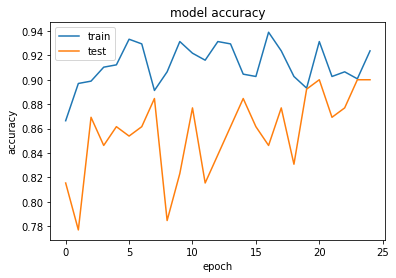

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

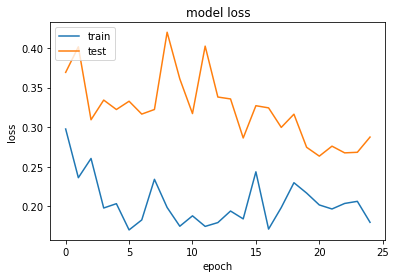

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.layers.pop(0)
#model.layers.pop(0)
newInput = tf.keras.layers.Input(batch_shape=(None,224,224,3))
newOutputs = model(newInput)
newModel = tf.keras.Model(newInput, newOutputs)
newModel.summary()

In [ ]:
newModel.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
newModel.evaluate(val_ds)

In [ ]:
# Save model
OUT_MODEL_PATH= '/content/gdrive/MyDrive/Curso-Jetson/models'
model.save(os.path.join(OUT_MODEL_PATH, 'model-final-blinkDetection.hdf5'))
model.save(os.path.join(OUT_MODEL_PATH, 'model-final-blinkDetection'))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Curso-Jetson/models/model-final-blinkDetection/assets


In [ ]:
!ls $OUT_MODEL_PATH

model-final-blinkDetection	 model-final-pract1.hdf5
model-final-blinkDetection.hdf5  model-final-pract2
model-final-pract1		 model-final-pract2.hdf5
